In [1]:
import setproctitle

setproctitle.setproctitle(f"ANN_BENCHMARK")

In [2]:
import os
import time
import json
import annoy
import numpy as np
import scann
from tqdm.notebook import tqdm
from sklearn.metrics import ndcg_score

2022-05-09 06:35:59.660904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-09 06:35:59.660943: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
emb_train = np.load("/home/asciishell/s3/asciishell-fsod/RunYoloV2/valid_emb.npy").astype(np.float32)
emb_test = np.load("/home/asciishell/s3/asciishell-fsod/RunYolo/categories_emb.npy").astype(np.float32)
emb_train.shape, emb_test.shape

((852831, 512), (1203, 512))

In [4]:
NEIGHBOR_SIZE = 30

In [5]:
experimets = []

In [6]:
def cos_sim_matrix(a, b):
    return np.dot(a, b) / np.linalg.norm(b)


def get_ns_by_vector(vec, n):
    vec = vec.astype(np.float32)
    dist = cos_sim_matrix(emb_train, vec)
    idx = np.argsort(dist)
    top_idx = idx[: -n - 1 : -1]
    return top_idx, dist

In [7]:
true_neig = []
start = time.time()
for vec in tqdm(emb_test):
    neig, dist = get_ns_by_vector(vec, len(emb_train))
    true_neig.append(neig[:1000].copy())
end = time.time()
true_neig = np.array(true_neig)
experimets.append(
    {
        "name": "BF",
        "build_time": 0,
        "time": end - start,
        "recall": 1,
        "ndcg": 1,
    }
)

  0%|          | 0/1203 [00:00<?, ?it/s]

In [8]:
def compute_recall(neighbors, true_neighbors):
    total = 0
    for gt_row, row in zip(true_neighbors, neighbors):
        total += np.intersect1d(gt_row, row).shape[0]
    return total / true_neighbors.size

# Annoy

In [9]:
for size in tqdm([5, 50, 100, 250, 500, 1000, 2000]):
    start = time.time()
    t = annoy.AnnoyIndex(emb_train.shape[1], "angular")
    for i, v in enumerate(emb_train):
        t.add_item(i, v)
    t.build(size)
    build_time = time.time() - start

    start = time.time()
    neighbors = []
    for vec in emb_test:
        neig, dist = t.get_nns_by_vector(vec, NEIGHBOR_SIZE, include_distances=True)
        neighbors.append(neig)
    query_time = time.time() - start
    neighbors = np.array(neighbors)

    experimets.append(
        {
            "name": "Annoy_{}".format(t.get_n_trees()),
            "build_time": build_time,
            "time": query_time,
            "recall": compute_recall(neighbors, true_neig[:, :30]),
            "ndcg": ndcg_score(true_neig[:, :30], neighbors),
        }
    )
    print(experimets[-1])


  0%|          | 0/7 [00:00<?, ?it/s]

{'name': 'Annoy_5', 'build_time': 33.39054775238037, 'time': 0.20062565803527832, 'recall': 0.04546965918536991, 'ndcg': 0.8383973100310024}
{'name': 'Annoy_50', 'build_time': 44.913474559783936, 'time': 0.7518095970153809, 'recall': 0.16115267387087837, 'ndcg': 0.8414715198373985}
{'name': 'Annoy_100', 'build_time': 60.77546215057373, 'time': 1.2996938228607178, 'recall': 0.23203103352729287, 'ndcg': 0.8429523699728156}
{'name': 'Annoy_250', 'build_time': 102.70256018638611, 'time': 2.728666305541992, 'recall': 0.36411748406760874, 'ndcg': 0.8464349453352958}
{'name': 'Annoy_500', 'build_time': 174.94754767417908, 'time': 4.822695255279541, 'recall': 0.45852036575228594, 'ndcg': 0.851302384162423}
{'name': 'Annoy_1000', 'build_time': 323.5422558784485, 'time': 8.530762195587158, 'recall': 0.5426156830146855, 'ndcg': 0.8578699367201398}
{'name': 'Annoy_2000', 'build_time': 615.1167879104614, 'time': 15.330833196640015, 'recall': 0.6186478248822388, 'ndcg': 0.8689125335827335}


# ScaNN

In [19]:
tasks = []
for leaves in [500, 2000, 5000, 10_000]:
    for leaves_search in [0.1, 0.5, 0.9]:
        for reorder in [50, 100, 500]:
            tasks.append({
                'leaves': leaves,
                'leaves_search': leaves_search,
                'reorder': reorder,
            })

In [20]:
for row in tqdm(tasks):
    num_leaves_to_search = int(row["leaves"] * row["leaves_search"])
    start = time.time()
    searcher = (
        scann.scann_ops_pybind.builder(emb_train, 30, "dot_product")
        .tree(num_leaves=row["leaves"], num_leaves_to_search=num_leaves_to_search, training_sample_size=len(emb_train))
        .score_ah(2, anisotropic_quantization_threshold=0.2)
        .reorder(row["reorder"])
        .build()
    )
    build_time = time.time() - start

    start = time.time()
    neighbors = []
    for vec in emb_test:
        neig, dist = searcher.search(vec, NEIGHBOR_SIZE)
        neighbors.append(neig)
    query_time = time.time() - start
    neighbors = np.array(neighbors)

    experimets.append(
        {
            "name": "ScaNN_{}".format(json.dumps(row)),
            "build_time": build_time,
            "time": query_time,
            "recall": compute_recall(neighbors, true_neig[:, :30]),
            "ndcg": ndcg_score(true_neig[:, :30], neighbors),
        }
    )
    print(experimets[-1])

  0%|          | 0/36 [00:00<?, ?it/s]

[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:06:04.198361: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:06:16.495528: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 12.297081022s.


{'name': 'ScaNN_{"leaves": 500, "leaves_search": 0.1, "reorder": 50}', 'build_time': 38.102540254592896, 'time': 0.9346880912780762, 'recall': 0.7098365198115821, 'ndcg': 0.8774075538790683}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:06:43.342574: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:06:55.324687: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 11.982028776s.


{'name': 'ScaNN_{"leaves": 500, "leaves_search": 0.1, "reorder": 100}', 'build_time': 37.62420439720154, 'time': 0.9929089546203613, 'recall': 0.8389027431421446, 'ndcg': 0.900886383189927}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:07:22.042319: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:07:34.456124: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 12.413724324s.


{'name': 'ScaNN_{"leaves": 500, "leaves_search": 0.1, "reorder": 500}', 'build_time': 38.21630668640137, 'time': 1.1187522411346436, 'recall': 0.9054031587697423, 'ndcg': 0.927346861771196}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:08:01.501385: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:08:14.044792: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 12.543309004s.


{'name': 'ScaNN_{"leaves": 500, "leaves_search": 0.5, "reorder": 50}', 'build_time': 38.37389922142029, 'time': 5.656149387359619, 'recall': 0.7412856747021336, 'ndcg': 0.8856686147541323}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:08:45.579897: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:08:57.923108: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 12.343124073s.


{'name': 'ScaNN_{"leaves": 500, "leaves_search": 0.5, "reorder": 100}', 'build_time': 37.973384380340576, 'time': 5.6103901863098145, 'recall': 0.8915211970074813, 'ndcg': 0.9242088476683811}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:09:29.220458: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:09:41.441200: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 12.220659236s.


{'name': 'ScaNN_{"leaves": 500, "leaves_search": 0.5, "reorder": 500}', 'build_time': 37.979209899902344, 'time': 5.802263259887695, 'recall': 0.9835965641451926, 'ndcg': 0.9779715293370631}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:10:13.068696: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:10:25.441314: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 12.372531022s.


{'name': 'ScaNN_{"leaves": 500, "leaves_search": 0.9, "reorder": 50}', 'build_time': 38.21839761734009, 'time': 9.998576879501343, 'recall': 0.7441119423663065, 'ndcg': 0.887575914291124}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:11:01.431714: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:11:13.912299: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 12.480490496s.


{'name': 'ScaNN_{"leaves": 500, "leaves_search": 0.9, "reorder": 100}', 'build_time': 38.3338463306427, 'time': 10.18532943725586, 'recall': 0.8976447769465226, 'ndcg': 0.9306912768787227}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:11:49.993358: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:12:02.167404: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 12.173958895s.


{'name': 'ScaNN_{"leaves": 500, "leaves_search": 0.9, "reorder": 500}', 'build_time': 38.09277367591858, 'time': 10.022528886795044, 'recall': 0.9948185092823497, 'ndcg': 0.9943966579519208}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:12:38.203401: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:13:16.371256: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 38.167766228s.


{'name': 'ScaNN_{"leaves": 2000, "leaves_search": 0.1, "reorder": 50}', 'build_time': 64.22450304031372, 'time': 1.265932321548462, 'recall': 0.7527015793848711, 'ndcg': 0.8841634577163238}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:13:43.774466: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:14:21.722179: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 37.947625767s.


{'name': 'ScaNN_{"leaves": 2000, "leaves_search": 0.1, "reorder": 100}', 'build_time': 64.02688217163086, 'time': 1.2639212608337402, 'recall': 0.886062621224716, 'ndcg': 0.9189976216135316}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:14:49.118252: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:15:27.131150: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 38.012812153s.


{'name': 'ScaNN_{"leaves": 2000, "leaves_search": 0.1, "reorder": 500}', 'build_time': 64.04238200187683, 'time': 1.4091260433197021, 'recall': 0.9497367691881408, 'ndcg': 0.9505707469883938}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:15:54.653695: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:16:32.786864: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 38.13308688s.


{'name': 'ScaNN_{"leaves": 2000, "leaves_search": 0.5, "reorder": 50}', 'build_time': 64.32871198654175, 'time': 6.8460915088653564, 'recall': 0.7670268772513161, 'ndcg': 0.891862201926546}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:17:05.915703: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:17:44.157397: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 38.241601184s.


{'name': 'ScaNN_{"leaves": 2000, "leaves_search": 0.5, "reorder": 100}', 'build_time': 64.12865376472473, 'time': 6.830048084259033, 'recall': 0.9119977833194791, 'ndcg': 0.9347096091687577}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:18:16.956760: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:18:55.197197: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 38.240353292s.


{'name': 'ScaNN_{"leaves": 2000, "leaves_search": 0.5, "reorder": 500}', 'build_time': 64.44151735305786, 'time': 6.890282392501831, 'recall': 0.9912164034358548, 'ndcg': 0.9879124387543947}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:19:28.351036: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:20:06.327555: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 37.97643387s.


{'name': 'ScaNN_{"leaves": 2000, "leaves_search": 0.9, "reorder": 50}', 'build_time': 63.83234524726868, 'time': 11.574501514434814, 'recall': 0.7680798004987531, 'ndcg': 0.8926342457284976}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:20:43.834940: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:21:21.906102: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 38.071081316s.


{'name': 'ScaNN_{"leaves": 2000, "leaves_search": 0.9, "reorder": 100}', 'build_time': 63.97715663909912, 'time': 11.682128190994263, 'recall': 0.9143530063729565, 'ndcg': 0.9373476944595971}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:21:59.577191: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:22:37.441291: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 37.864015838s.


{'name': 'ScaNN_{"leaves": 2000, "leaves_search": 0.9, "reorder": 500}', 'build_time': 63.90440559387207, 'time': 12.08577036857605, 'recall': 0.9961762261014131, 'ndcg': 0.9955637595916447}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:23:15.645455: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:24:45.364027: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 1m29.718479661s.


{'name': 'ScaNN_{"leaves": 5000, "leaves_search": 0.1, "reorder": 50}', 'build_time': 116.07712841033936, 'time': 1.8203003406524658, 'recall': 0.7731227486838459, 'ndcg': 0.8914512309269808}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:25:13.571374: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:26:42.950620: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 1m29.379160221s.


{'name': 'ScaNN_{"leaves": 5000, "leaves_search": 0.1, "reorder": 100}', 'build_time': 115.68043065071106, 'time': 1.8294148445129395, 'recall': 0.9102244389027432, 'ndcg': 0.9301134327348096}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:27:11.173597: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:28:40.717995: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 1m29.544316493s.


{'name': 'ScaNN_{"leaves": 5000, "leaves_search": 0.1, "reorder": 500}', 'build_time': 116.07758641242981, 'time': 2.098454713821411, 'recall': 0.9689387642006095, 'ndcg': 0.9640775766924381}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:29:09.476949: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:30:36.485702: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 1m27.008665298s.


{'name': 'ScaNN_{"leaves": 5000, "leaves_search": 0.5, "reorder": 50}', 'build_time': 112.47400093078613, 'time': 8.96124267578125, 'recall': 0.7800221668052092, 'ndcg': 0.8961422407562594}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:31:10.999440: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:32:35.172694: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 1m24.173172317s.


{'name': 'ScaNN_{"leaves": 5000, "leaves_search": 0.5, "reorder": 100}', 'build_time': 109.40464806556702, 'time': 9.008808374404907, 'recall': 0.9250484898863951, 'ndcg': 0.9408300147116927}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:33:09.452068: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:34:34.291636: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 1m24.839477993s.


{'name': 'ScaNN_{"leaves": 5000, "leaves_search": 0.5, "reorder": 500}', 'build_time': 109.75634956359863, 'time': 8.739070415496826, 'recall': 0.9942920476586312, 'ndcg': 0.99077200294828}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:35:07.975446: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:36:32.416919: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 1m24.441391051s.


{'name': 'ScaNN_{"leaves": 5000, "leaves_search": 0.9, "reorder": 50}', 'build_time': 110.42578387260437, 'time': 16.161819458007812, 'recall': 0.7806871709614852, 'ndcg': 0.8969972658417454}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:37:14.704462: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:38:45.390126: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 1m30.685572195s.


{'name': 'ScaNN_{"leaves": 5000, "leaves_search": 0.9, "reorder": 100}', 'build_time': 117.20485234260559, 'time': 15.402585744857788, 'recall': 0.9265170407315045, 'ndcg': 0.9422697236453447}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:39:27.398769: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:40:56.835962: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 1m29.437102503s.


{'name': 'ScaNN_{"leaves": 5000, "leaves_search": 0.9, "reorder": 500}', 'build_time': 115.79392910003662, 'time': 15.375367879867554, 'recall': 0.9976170684400111, 'ndcg': 0.9966423405421344}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:41:38.596558: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:44:32.925451: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 2m54.328796192s.


{'name': 'ScaNN_{"leaves": 10000, "leaves_search": 0.1, "reorder": 50}', 'build_time': 205.60001063346863, 'time': 3.2111473083496094, 'recall': 0.7804100858963702, 'ndcg': 0.8944068959394404}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:45:07.524190: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:48:05.668030: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 2m58.143733306s.


{'name': 'ScaNN_{"leaves": 10000, "leaves_search": 0.1, "reorder": 100}', 'build_time': 209.4417667388916, 'time': 2.9656879901885986, 'recall': 0.914657799944583, 'ndcg': 0.933379173003863}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:48:39.965217: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:51:36.270533: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 2m56.305209343s.


{'name': 'ScaNN_{"leaves": 10000, "leaves_search": 0.1, "reorder": 500}', 'build_time': 207.57821989059448, 'time': 3.238398551940918, 'recall': 0.9735106677750069, 'ndcg': 0.9687713808295506}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:52:10.843187: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:55:04.407619: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 2m53.564337295s.


{'name': 'ScaNN_{"leaves": 10000, "leaves_search": 0.5, "reorder": 50}', 'build_time': 203.9434940814972, 'time': 12.189081907272339, 'recall': 0.786118038237739, 'ndcg': 0.8976131947046355}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:55:47.054694: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 07:58:29.375319: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 2m42.320504101s.


{'name': 'ScaNN_{"leaves": 10000, "leaves_search": 0.5, "reorder": 100}', 'build_time': 190.69445252418518, 'time': 12.523913383483887, 'recall': 0.9264616237184816, 'ndcg': 0.9421052767437248}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 07:59:10.366591: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 08:01:50.625675: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 2m40.258941119s.


{'name': 'ScaNN_{"leaves": 10000, "leaves_search": 0.5, "reorder": 500}', 'build_time': 188.98035407066345, 'time': 12.101403951644897, 'recall': 0.9944582986977002, 'ndcg': 0.9915720501793028}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 08:02:31.501427: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 08:05:11.885419: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 2m40.383884744s.


{'name': 'ScaNN_{"leaves": 10000, "leaves_search": 0.9, "reorder": 50}', 'build_time': 188.83107233047485, 'time': 20.410709142684937, 'recall': 0.786339706289831, 'ndcg': 0.8959620405140044}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 08:06:00.815634: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 08:08:38.749689: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 2m37.933953289s.


{'name': 'ScaNN_{"leaves": 10000, "leaves_search": 0.9, "reorder": 100}', 'build_time': 186.44897866249084, 'time': 20.991503715515137, 'recall': 0.9277362150180105, 'ndcg': 0.9435553019238285}


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-09 08:09:28.348307: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 852831
2022-05-09 08:12:06.208681: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 2m37.860289632s.


{'name': 'ScaNN_{"leaves": 10000, "leaves_search": 0.9, "reorder": 500}', 'build_time': 186.00796627998352, 'time': 21.087839603424072, 'recall': 0.9978664449986145, 'ndcg': 0.9977351451272201}


# NMSLib

In [23]:
import nmslib

In [29]:
tasks = []
for M in [8, 16, 32, 48]:
    for post in [0, 2]:
        for efConstruction in [400, 800, 1600]:
            tasks.append({
                'M': M,
                'post': post,
                'efConstruction': efConstruction,
            })

In [50]:
for row in tqdm(tasks[2:]):
    start = time.time()
    index = nmslib.init(method='hnsw', space='cosinesimil')
    index.addDataPointBatch(emb_train)
    index.createIndex(row, print_progress=False)
    build_time = time.time() - start

    start = time.time()
    neighbors = []
    for vec in emb_test:
        neig, dist = index.knnQuery(vec, NEIGHBOR_SIZE)
        neighbors.append(neig)
    query_time = time.time() - start
    neighbors = np.array([np.hstack([neig, [-1] * NEIGHBOR_SIZE])[:NEIGHBOR_SIZE] for neig in neighbors])

    experimets.append(
        {
            "name": "NMSLib_{}".format(json.dumps(row)),
            "build_time": build_time,
            "time": query_time,
            "recall": compute_recall(neighbors, true_neig[:, :30]),
            "ndcg": ndcg_score(true_neig[:, :30], neighbors),
        }
    )
    print(experimets[-1])

  0%|          | 0/22 [00:00<?, ?it/s]

{'name': 'NMSLib_{"M": 8, "post": 0, "efConstruction": 1600}', 'build_time': 281.025386095047, 'time': 0.11313605308532715, 'recall': 0.3855915766140205, 'ndcg': 0.8446568866837015}
{'name': 'NMSLib_{"M": 8, "post": 2, "efConstruction": 400}', 'build_time': 159.4739179611206, 'time': 0.14585423469543457, 'recall': 0.501219174286506, 'ndcg': 0.8517295742652308}
{'name': 'NMSLib_{"M": 8, "post": 2, "efConstruction": 800}', 'build_time': 293.7391712665558, 'time': 0.1353168487548828, 'recall': 0.5052369077306733, 'ndcg': 0.8487742371096397}
{'name': 'NMSLib_{"M": 8, "post": 2, "efConstruction": 1600}', 'build_time': 549.2597508430481, 'time': 0.1435079574584961, 'recall': 0.4972014408423386, 'ndcg': 0.8479791137731587}
{'name': 'NMSLib_{"M": 16, "post": 0, "efConstruction": 400}', 'build_time': 123.29502534866333, 'time': 0.17882084846496582, 'recall': 0.47791632031033526, 'ndcg': 0.8486602980005634}
{'name': 'NMSLib_{"M": 16, "post": 0, "efConstruction": 800}', 'build_time': 228.58638525

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(experimets).to_csv('ann.csv', index=False)

In [59]:
df = pd.read_csv('ann.csv')
df = df[df['recall'] > 0.2]
df['qps'] =  len(emb_test) / df['time']

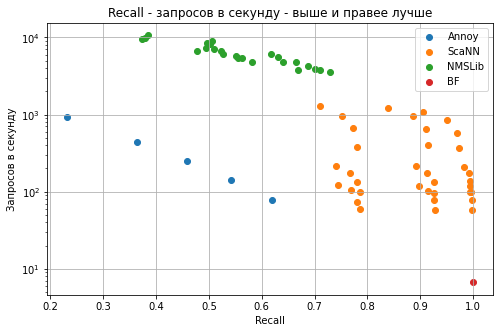

In [77]:
plt.figure(figsize=(8, 5), facecolor='w')
for name in ['Annoy', 'ScaNN', 'NMSLib', 'BF']:
    x = df[df['name'].str.startswith(name)].sort_values('recall')
    plt.scatter(x['recall'], x['qps'], label=name)
plt.yscale('log')
# plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Запросов в секунду')
plt.title('Recall - запросов в секунду - выше и правее лучше')
plt.savefig('ann_recall_qps.png', bbox_inches ='tight')
plt.show()

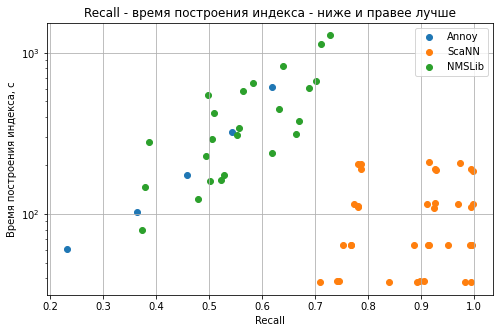

In [78]:
plt.figure(figsize=(8, 5), facecolor='w')
for name in ['Annoy', 'ScaNN', 'NMSLib']:
    x = df[df['name'].str.startswith(name)].sort_values('recall')
    plt.scatter(x['recall'], x['build_time'], label=name)
plt.yscale('log')
# plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Время построения индекса, с')
plt.title('Recall - время построения индекса - ниже и правее лучше')
plt.savefig('ann_recall_build.png', bbox_inches ='tight')
plt.show()